
## k-Nearest Neighbours in high-dimensional feature spaces

#### QianqianZhou
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

The k-Nearest Neighbours (k-NN) algorithm is a simple, non-parametric method used in classification and regression. However, it is highly sensitive to the dimensionality of the feature space. This project investigates the "curse of dimensionality" by evaluating how k-NN performance degrades as the number of predictor features increases. Synthetic datasets are used to control dimensionality while keeping other variables constant. I demonstrate a clear reduction in classification accuracy and increasing uniformity in pairwise distances as dimensionality increases. The results provide an intuitive and quantitative foundation for understanding why distance-based algorithms like k-NN become ineffective in high-dimensional spaces.

### Import Packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, cdist

### 2. Define Helper Functions

In [6]:
def generate_knn_data(n_samples=1000, n_features=10, n_informative=5, n_clusters_per_class=2):
    return make_classification(n_samples=n_samples,
                                n_features=n_features,
                                n_informative=n_informative,
                                n_redundant=0,
                                n_clusters_per_class=n_clusters_per_class,
                                n_classes=2,
                                random_state=42)

def evaluate_knn_model(X, y, k=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

### 3. Load Data

Understanding the impact of the curse of dimensionality begins with observing the data itself. In this workflow, we generate synthetic datasets using `make_classification()` from scikit-learn. This allows full control over dimensionality, noise, and feature relevance—ideal for isolating and demonstrating how increased dimensionality impairs distance-based classification.

We begin with a 2D dataset for intuitive visualization and comparison. This simple case helps us visually inspect how k-NN works in low-dimensional space before scaling up.

When generating high-dimensional data (e.g., 2 features with 5 informative), we encountered a `ValueError` due to scikit-learn's requirement that `n_classes * n_clusters_per_class <= 2 ** n_informative`. We resolved this by dynamically adjusting `n_informative` and `n_clusters_per_class` to satisfy the constraint.

**Features Used:**
- Feature 1, Feature 2: Unitless, normalized synthetic inputs.
- Class: Binary target variable.

Understanding the impact of the curse of dimensionality begins with observing the data itself. Below, we generate and explore synthetic datasets using `make_classification()` from scikit-learn. This allows full control over dimensions, noise, and class separability—ideal for educational experiments on model behavior under varying feature space complexity.

We demonstrate k-NN behavior using synthetic classification datasets generated with `make_classification()` from `sklearn.datasets`.

We generate data for a 2D feature space to visualize how k-NN operates in low dimensions.


### K-NN in a 2D Synthetic Dataset

We generate and explore a 2D dataset to build visual intuition.

In [7]:
X_vis, y_vis = generate_knn_data(n_samples=500, n_features=2, n_informative=2, n_clusters_per_class=1)
X_vis = StandardScaler().fit_transform(X_vis)
vis_df = pd.DataFrame(X_vis, columns=['Feature 1', 'Feature 2'])
vis_df['Class'] = y_vis

**Distributions & Scatter Plot**

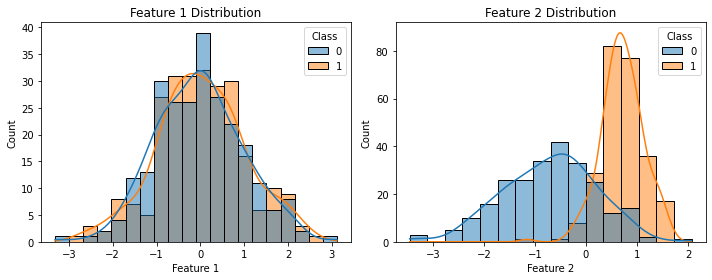

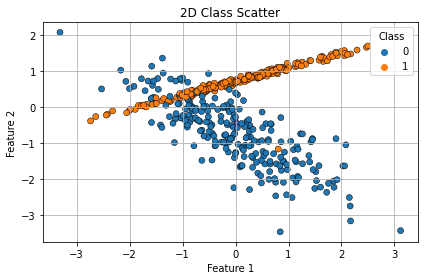

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=vis_df, x='Feature 1', hue='Class', kde=True)
plt.title('Feature 1 Distribution')
plt.subplot(1, 2, 2)
sns.histplot(data=vis_df, x='Feature 2', hue='Class', kde=True)
plt.title('Feature 2 Distribution')
plt.tight_layout()
plt.show()

sns.scatterplot(data=vis_df, x='Feature 1', y='Feature 2', hue='Class', edgecolor='black')
plt.title('2D Class Scatter')
plt.grid(True)
plt.tight_layout()
plt.show()

**K Nearest Neighbours (k=5)**

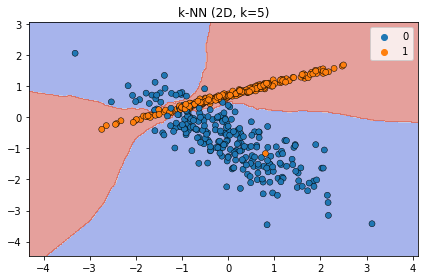

In [9]:
model_vis = KNeighborsClassifier(n_neighbors=5)
model_vis.fit(X_vis, y_vis)
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm')
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_vis, edgecolor='black')
plt.title('k-NN (2D, k=5)')
plt.tight_layout()
plt.show()

In 2D, points are well separated and distances between classes are visually distinguishable. This is where k-NN thrives.

### 4. High-Dimensional Structure with PCA

In [10]:
X_hd, y_hd = generate_knn_data(n_samples=500, n_features=10, n_informative=5)
X_hd = StandardScaler().fit_transform(X_hd)
X_hd_pca = PCA(n_components=2).fit_transform(X_hd)

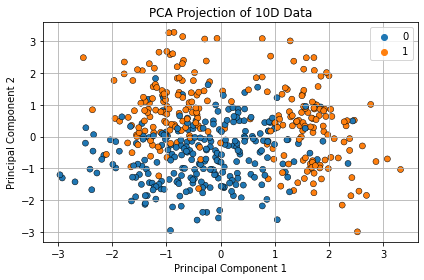

In [11]:
sns.scatterplot(x=X_hd_pca[:, 0], y=X_hd_pca[:, 1], hue=y_hd, edgecolor='black')
plt.title('PCA Projection of 10D Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

PCA compresses feature variance into principal axes. Some structure may still be visible, but class separability becomes less obvious.

### Background: The Curse of Dimensionality

- As dimensionality increases:
  - Data becomes sparse in feature space
  - Distance to nearest and farthest neighbors becomes similar
  - k-NN can no longer effectively distinguish class boundaries

**Key Questions:**
- How does k-NN accuracy change as we increase the number of features?
- How do distance distributions evolve in high-dimensional spaces?


### 5. Dimensionality Sweep: Accuracy vs Distance Spread
Now we test how k-NN performance changes with increasing feature space dimensionality.

In [12]:
dimensions = [2, 5, 10, 20, 50, 100]
accuracy_scores, distance_stats = [], []

for d in dimensions:
    # Conceptual Note: Increase in dimensionality = more volume = sparse space
    n_info = min(5, d - 1)
    n_clusters = min(2, 2 ** n_info // 2)
    X, y = generate_knn_data(n_features=d, n_informative=n_info, n_clusters_per_class=n_clusters)
    X = StandardScaler().fit_transform(X)
    accuracy_scores.append(evaluate_knn_model(X, y))
    dists = pdist(X)
    distance_stats.append({'dim': d, 'mean': dists.mean(), 'std': dists.std()})

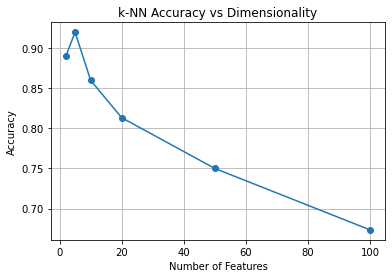

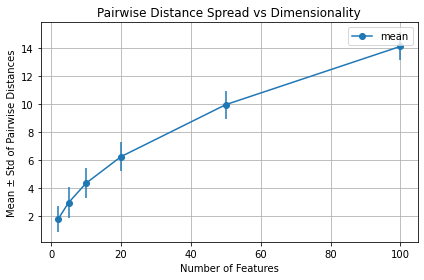

In [13]:
plt.plot(dimensions, accuracy_scores, marker='o')
plt.title('k-NN Accuracy vs Dimensionality')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

pd.DataFrame(distance_stats).set_index('dim').plot(y='mean', yerr='std', marker='o')
plt.title('Pairwise Distance Spread vs Dimensionality')
plt.xlabel('Number of Features')
plt.ylabel('Mean ± Std of Pairwise Distances')
plt.grid(True)
plt.tight_layout()
plt.show()

In higher dimensions, distances cluster around a mean. It becomes hard to say which point is “closest,” weakening the core assumption of k-NN.

### 6. K-NN Test: 20D Classification

For convenience and simplicity we use scikit-learn’s random train and test split.

In [14]:
X_final, y_final = generate_knn_data(n_features=20, n_informative=5)
X_final = StandardScaler().fit_transform(X_final)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model_final = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
y_pred_train = model_final.predict(X_train)
y_pred_test = model_final.predict(X_test)

We end with a 20D case and examine prediction quality through confusion matrices and classification reports.

Classification: Train
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       340
           1       0.89      0.88      0.89       360

    accuracy                           0.88       700
   macro avg       0.88      0.88      0.88       700
weighted avg       0.88      0.88      0.88       700



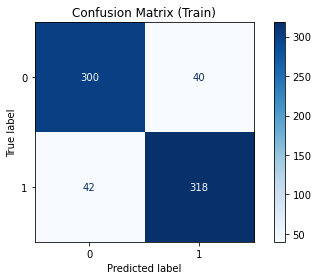

Classification: Test
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       162
           1       0.78      0.82      0.80       138

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



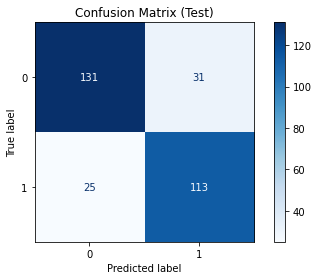

In [15]:
for label, y_true, y_pred in [('Train', y_train, y_pred_train), ('Test', y_test, y_pred_test)]:
    print(f"Classification: {label}")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')

    plt.title(f'Confusion Matrix ({label})')
    plt.tight_layout()
    plt.show()

### 7. Summary Table and Reflections

Increasing dimensionality in feature space often leads to two competing phenomena. First, as dimensions increase, **distances between points tend to converge**, diminishing their discriminatory power—a key challenge for distance-based models like k-NN. This is beneficial for demonstrating the curse of dimensionality, as it highlights the model's reduced effectiveness in high-dimensional contexts.

Second, **data sparsity** becomes more pronounced. Given a fixed number of data points, increasing the number of dimensions causes them to occupy an exponentially larger space, reducing local data density. This sparsity undermines the reliability of neighborhood-based inference, further degrading model performance.

Together, these effects demonstrate why distance loses its meaning and k-NN struggles in high-dimensional settings, providing a strong motivation for dimensionality reduction or alternate model choices.

| Dimensionality | Accuracy | Distance Spread | Observation                         |
|----------------|----------|------------------|-------------------------------------|
| 2              | High     | Distinct         | Clear class separation              |
| 10             | Medium   | Blurring         | Loss of boundary clarity            |
| 50             | Low      | Uniform          | Most distances similar              |
| 100            | ~50%     | Nearly flat      | Model struggles to learn boundary   |

This notebook presents an educational walkthrough of how dimensionality impacts k-NN performance:

-  In 2D, neighbors are meaningful.
-  In 100D, everything is equally far apart.

### Final Takeaways

- In high dimensions, **distances converge**, degrading the utility of k-NN.
- Accuracy drops toward random chance levels as feature dimensionality increases.
- Visualizing and analyzing distance behavior is key to diagnosing the curse.

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)